In [553]:
import torch
from torch import empty
torch.set_grad_enabled(False)
import math
import matplotlib.pyplot as plt


In [554]:
class Module(object) :
    
    def forward (self , *input) :
        raise NotImplementedError
    def backward (self , *gradwrtoutput):
        raise NotImplementedError

    def update_params(self, step_size):
        return
    def zero_grad(self):
        return
    def param(self):
        return []

In [555]:
class ReLU(Module):
    
    def __init__(self):
        self.input = None
        return
        
    def forward(self, input) :
        self.input = input.clone()
        return input.clamp(min=0)
    
    def backward(self, grad_output):
        assert(self.input is not None)
        assert(grad_output.size() == self.input.size())
        
        grad_input = grad_output.clone()
        grad_input[self.input < 0] = 0
        return grad_input
        
    __call__ = forward

In [556]:
class Tanh(Module):
    
    def forward(self, input):
        return torch.tanh(input)
    def backward (self, *gradwrtoutput):
        raise NotImplementedError

In [557]:
class LossMSE(Module):
    def __init__(self):
        return
    
    def forward(self, input, target):
        """
        Compute the mean square error loss between 
        the input tensor and the target tensor.

        Args:
        input -- tensor of size (N, *)
        target -- tensor of size (N, *)

        Returns:
        loss -- mse loss between input and target, loss = 
        """
    
        assert(input.size() == target.size())

        N = input.size(0)
        loss = (target-input).pow(2).sum()
        loss = 1/(2*N) * loss
        return loss
    
    def backward(self, input, target):
        assert(input.size() == target.size())
        N = input.size(0)
        return 1/N * (input-target)

In [558]:
class Linear(Module):
   

    def __init__(self, in_features, out_features, bias=True):
        mean = 0
        std = 1
        self.in_features = in_features
        self.out_features = out_features
        self.params = []
        
        self.weight = torch.empty(size=(out_features, in_features)).normal_(mean=mean, std=std)
        self.dw = torch.zeros(size=(out_features, in_features))
        self.params.append((self.weight, self.dw))
        if bias:
            self.bias = torch.empty(out_features).normal_(mean=mean, std=std)
            self.db = torch.zeros(out_features)
            self.params.append((self.bias, self.db))
        else:
            self.bias = None
            self.db = None
        
      
        
        
    def forward(self, input):
        """
        Forward the input data by applying a linear transformation on it.
        
        Args:
        input -- tensor of size (N, *, in_features)
        
        Returns:
        output -- tensor of size (N, *, out_features),  output = input @ weight.T + bias
        """
        
        assert(input.size(-1) == self.in_features)
        
        
        # Required information for the backward pass.
        # We clone to ensure that input won't be modified by the user before
        # calling backward.
        self.input = input.clone()
        
        output = input @ self.weight.T
        if self.bias is not None:
            output += self.bias
        return output
        
    def backward(self, grad_output):
        """
        Compute the derivative w.r.t. the input of the layer
        given the derivate w.r.t. to the output of the layer.
        
        Args:
        grad_output -- tensor of size (N, *, out_features)
        
        Returns 
        grad_input -- tensor of size (N, * , in_features), grad_input = grad_output @ weight
        """

        assert(grad_output.size(-1) == self.out_features)
        
        grad_input = grad_output @ self.weight
        
        if self.bias is not None:
            self.db += grad_output.sum(axis=0)
        self.dw += grad_output.T @  self.input
        
        return grad_input
       
    def zero_grad(self):
        """
        Sets the gradient w.r.t. the parametes to zero i.e.
        """
        
        self.dw = torch.zeros(size=(self.out_features, self.in_features))
        
        if self.bias is not None:
            self.db = torch.zeros(self.out_features)
        return
    
    def param(self):
        """
        Returns:
        params -- a list of pairs, each composed of a parameter tensor, 
        and a gradient tensor of same size.
        """
        
        # We just return a copy as we don't want the user
        # to be able to change the params of the model through this method.
        params = self.params.copy() 
        return params 
    

    def update_params(self, step_size):
        """
        Update the parameters of the linear layer going 
        in the opposite direction of the gradient.
        
        Args:
        step_size -- the size of an update step
        """
        
        self.weight -= step_size * self.dw
        if self.bias is not None:
            self.bias -= step_size * self.db
        return

In [559]:
class Sequential(Module):
    
    def __init__(self, *modules):
        self.modules = list(modules)
        
    
        
    def forward(self, input):
        output = input
        for module in self.modules:
            output = module.forward(output)
        return output
    
    def backward(self, grad_output):
        grad_input = grad_output
        self.modules.reverse()
        for module in self.modules:
            grad_input = module.backward(grad_input)
        self.modules.reverse()
        return grad_input
    
    def zero_grad(self):
        """
        Sets the gradient w.r.t. the parametes to zero i.e.
        """
        for module in self.modules:
            module.zero_grad() 
        return
    
    def param(self):
        """
        Returns:
        params -- a list of pairs, each composed of a parameter tensor, 
        and a gradient tensor of same size.
        """
        params = []
        for module in self.modules:
            params.append(module.param())
        return params
    

    def update_params(self, step_size):
        """
        Update the parameters of the linear layer going 
        in the opposite direction of the gradient.
        
        Args:
        step_size -- the size of an update step
        """
        
        for module in self.modules:
            module.update_params(step_size) 
        return

# First Test 

(-1, 1)

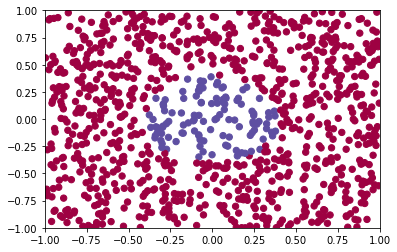

In [621]:
#generate random data -- not linearly separable 
a, b = -1, 1
N = 1000 # number of points 
D = 2 # dimensionality
K = 2 # number of classes
X_train = torch.empty(N,2).uniform_(a,b)
X_test = torch.empty(N,2).uniform_(a,b)

y_train = ((X_train[:,0]**2 + X_train[:,1]**2) < 1/(2*math.pi)).double()
y_test = ((X_test[:,0]**2 + X_test[:,1]**2) < 1/(2*math.pi)).double()

fig = plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [622]:
y_train[0:10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

In [623]:
y = torch.empty(y_train.size(0), 2)
print(y.size())
for idx in range(y_train.size(0)):
    if y_train[idx] == 0:
        a = 0
        b = 1.
    else:
        a = 1.
        b = 0.
    y[idx,0] = a
    y[idx,1] = b

torch.Size([1000, 2])


In [624]:
y[0:20]

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])

In [625]:
model = Sequential(Linear(2,25),ReLU(), Linear(25,25),ReLU(), Linear(25,25),ReLU(), Linear(25,2))
loss_module = LossMSE()

In [626]:
#train model
epoch = 10000
for e in range(epoch):
    output = model.forward(X_train)
    loss = loss_module.forward(output, y)
    if e%1000 == 0:
        print("loss: {0}".format(loss))
    dloss = loss_module.backward(output, y)
    model.backward(dloss)
    model.update_params(0.001)
    model.zero_grad()

loss: 975.347412109375
loss: 0.1893848329782486
loss: 0.13469479978084564
loss: 0.11036138981580734
loss: 0.09587875008583069
loss: 0.08542317152023315
loss: 0.07815971225500107
loss: 0.07245656102895737
loss: 0.06823067367076874
loss: 0.06522019952535629


In [602]:
import numpy as np

tensor([[0.5395, 1.9078],
        [0.6335, 1.8248],
        [0.6138, 1.7151],
        [0.5942, 1.6053],
        [0.5745, 1.4956],
        [0.5549, 1.3858],
        [0.5352, 1.2761],
        [0.5155, 1.1663],
        [0.4959, 1.0566],
        [0.4158, 1.0019]])


(-0.9975085258483887, 0.9824895858764648)

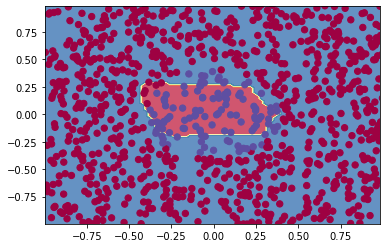

In [627]:
# plot the classifiers-- RELU
h = 0.02
x_min, x_max = X_test[:, 0].min(), X_test[:, 0].max()
y_min, y_max = X_test[:, 1].min(), X_test[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

myX = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()
Z = torch.tensor(np.zeros((myX.shape[0],K))).double()
Z = model.forward(myX)
print(Z[0:10])
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)


fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Little example with few layers

In [543]:
l1 = Linear(2,5)
l2 = Linear(5,10)
l3 = Linear(10,3)
r1 = ReLU()
r2 = ReLU()

In [544]:
model = Sequential(l1,r1, l2,r2, l3)
loss_module = LossMSE()

In [545]:
x = torch.empty(10,2).normal_()
real_w = torch.empty(3,2).normal_()
real_b = torch.empty(3).normal_()
y = x @ real_w.T + real_b

In [546]:
#train model
epoch = 1000
for e in range(epoch):
    output = model.forward(x)
    loss = loss_module.forward(output, y)
    if e%100 == 0:
        print("loss: {0}".format(loss))
    dloss = loss_module.backward(output, y)
    model.backward(dloss)
    model.update_params(0.001)
    model.zero_grad()

loss: 43.87044143676758
loss: 4.113137722015381
loss: 1.5851784944534302
loss: 1.1278547048568726
loss: 0.9454269409179688
loss: 0.8097853064537048
loss: 0.7099971771240234
loss: 0.625080943107605
loss: 0.5362294316291809
loss: 0.4763529896736145


# Little example with 1 linear Layer

In [540]:
linearLayer = Linear(2,3, bias=True)
loss_module = LossMSE()

#generate data
x = torch.empty(10,2).normal_()
real_w = torch.empty(3,2).normal_()
real_b = torch.empty(3).normal_()
y = x @ real_w.T + real_b
print(real_w)
print(real_b)

tensor([[ 0.2477,  0.5727],
        [ 1.3505,  0.2516],
        [ 0.8788, -0.3805]])
tensor([ 1.5689, -0.2951, -1.4344])


In [541]:
#train model
epoch = 1000
for e in range(epoch):
    output = linearLayer.forward(x)
    loss = loss_module.forward(output, y)
    if e%100 == 0:
        print("weight: {0}".format(linearLayer.weight))
        print("bias: {0}".format(linearLayer.bias))
        print("loss: {0}".format(loss))
    dloss = loss_module.backward(output, y)
    linearLayer.backward(dloss)
    linearLayer.update_params(0.1)
    linearLayer.zero_grad()

weight: tensor([[-0.2542, -0.6756],
        [ 0.3761, -0.8413],
        [-2.0694,  2.1834]])
bias: tensor([0.4356, 0.9977, 1.0921])
loss: 8.920021057128906
weight: tensor([[ 0.1345,  0.3111],
        [ 1.1387, -0.2325],
        [ 0.9162, -0.2844]])
bias: tensor([ 1.6611, -0.1228, -1.4651])
loss: 0.023080212995409966
weight: tensor([[ 0.2110,  0.4885],
        [ 1.2824,  0.0953],
        [ 0.8920, -0.3503]])
bias: tensor([ 1.5988, -0.2397, -1.4452])
loss: 0.0024013265501707792
weight: tensor([[ 0.2358,  0.5455],
        [ 1.3285,  0.2012],
        [ 0.8831, -0.3707]])
bias: tensor([ 1.5786, -0.2772, -1.4379])
loss: 0.0002499320835340768
weight: tensor([[ 0.2439,  0.5639],
        [ 1.3434,  0.2353],
        [ 0.8802, -0.3773]])
bias: tensor([ 1.5721, -0.2893, -1.4356])
loss: 2.601312371552922e-05
weight: tensor([[ 0.2465,  0.5699],
        [ 1.3482,  0.2463],
        [ 0.8792, -0.3795]])
bias: tensor([ 1.5700, -0.2932, -1.4348])
loss: 2.7075309390056645e-06
weight: tensor([[ 0.2473,  0.

In [542]:
print(real_w)
print(real_b)

tensor([[ 0.2477,  0.5727],
        [ 1.3505,  0.2516],
        [ 0.8788, -0.3805]])
tensor([ 1.5689, -0.2951, -1.4344])
